In [115]:
#------------------------------------------------------------------------------------------------
# Import
#------------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np

import copy
import os
import sys
import importlib
from joblib import load, dump

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from feature_engine.creation import CyclicalFeatures
from category_encoders import CatBoostEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.utils import class_weight

import xgboost as xgb
import shap

import warnings
warnings.filterwarnings("ignore")


In [116]:
#------------------------------------------------------------------------------------------------
# Load file
#------------------------------------------------------------------------------------------------

#df = load(r'_local/data_processed_2_preprocessing_1.2-leibold-data-preprocessing_concat.joblib')
#df = df.sample(n=70000)

#print(df.shape)
#display(df.head(3))


In [117]:
#------------------------------------------------------------------------------------------------
# Load joblib file with 2019-2024 preprocessed data for accidents, with target included
#------------------------------------------------------------------------------------------------

df_acc_severity = load(r'..\..\data\processed\2_preprocessing\1.1-simmler-data-preprocessing_accidents_severity_reordered.joblib')

display(df_acc_severity.head(3))
df_acc_severity.info()


,acc_num,acc_date,acc_year,acc_month,acc_hour,acc_department,acc_municipality,acc_metro,acc_long,acc_lat,acc_ambient_lightning,acc_atmosphere,acc_urbanization_level,acc_intersection,acc_collision_type,ind_num_veh,ind_severity
0,201900000001,2019-11-30,2019,11,1,93,93053,1,2.47012,48.89621,4.0,1.0,1,1.0,2.0,B01,2
2,201900000001,2019-11-30,2019,11,1,93,93053,1,2.47012,48.89621,4.0,1.0,1,1.0,2.0,A01,1
3,201900000002,2019-11-30,2019,11,2,93,93066,1,2.36880,48.93070,3.0,1.0,1,1.0,6.0,A01,2


<class 'pandas.core.frame.DataFrame'>
Index: 651785 entries, 0 to 125186
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   acc_num                 651785 non-null  int64         
 1   acc_date                651785 non-null  datetime64[ns]
 2   acc_year                651785 non-null  int64         
 3   acc_month               651785 non-null  int64         
 4   acc_hour                651785 non-null  int64         
 5   acc_department          651785 non-null  object        
 6   acc_municipality        651785 non-null  object        
 7   acc_metro               651785 non-null  int64         
 8   acc_long                651785 non-null  float64       
 9   acc_lat                 651785 non-null  float64       
 10  acc_ambient_lightning   651774 non-null  float64       
 11  acc_atmosphere          651747 non-null  float64       
 12  acc_urbanization_level  651785 non-

In [118]:
# -------------------------------------------------------------------------------------------------
# copy file
# -------------------------------------------------------------------------------------------------

df_acc_target = df_acc_severity.copy()
df_acc_target.head()


,acc_num,acc_date,acc_year,acc_month,acc_hour,acc_department,acc_municipality,acc_metro,acc_long,acc_lat,acc_ambient_lightning,acc_atmosphere,acc_urbanization_level,acc_intersection,acc_collision_type,ind_num_veh,ind_severity
0,201900000001,2019-11-30,2019,11,1,93,93053,1,2.470120,48.896210,4.0,1.0,1,1.0,2.0,B01,2
2,201900000001,2019-11-30,2019,11,1,93,93053,1,2.470120,48.896210,4.0,1.0,1,1.0,2.0,A01,1
3,201900000002,2019-11-30,2019,11,2,93,93066,1,2.368800,48.930700,3.0,1.0,1,1.0,6.0,A01,2
4,201900000003,2019-11-28,2019,11,15,92,92036,1,2.319174,48.935872,1.0,1.0,1,1.0,4.0,A01,1
5,201900000003,2019-11-28,2019,11,15,92,92036,1,2.319174,48.935872,1.0,1.0,1,1.0,4.0,A01,2


In [119]:
# -------------------------------------------------------------------------------------------------
# import lib_graph_2
# -------------------------------------------------------------------------------------------------

#colors
plot_color = 'deepskyblue'

colors_grav_org_order = {1: 'green', 2: 'darkred', 3: 'orange', 4: 'yellowgreen'}
colors_grav_reorder = {1: 'green', 2: 'yellowgreen', 3: 'orange', 4: 'darkred'}
colors_grav = colors_grav_org_order

sys.path.insert(1, '../2-data-preprocessing')
import lib_1_0_simmler_data_preprocessing_graph_1 as lib_graph_1
import lib_1_0_simmler_data_preprocessing_graph_2 as lib_graph_2

importlib.reload(lib_graph_1)
importlib.reload(lib_graph_2)


<module 'lib_1_0_simmler_data_preprocessing_graph_2' from 'C:\\Users\\User\\Repos\\RepoDS7\\SEP25-BDS-Road-Accidents\\notebooks\\2-data-preprocessing\\../2-data-preprocessing\\lib_1_0_simmler_data_preprocessing_graph_2.py'>

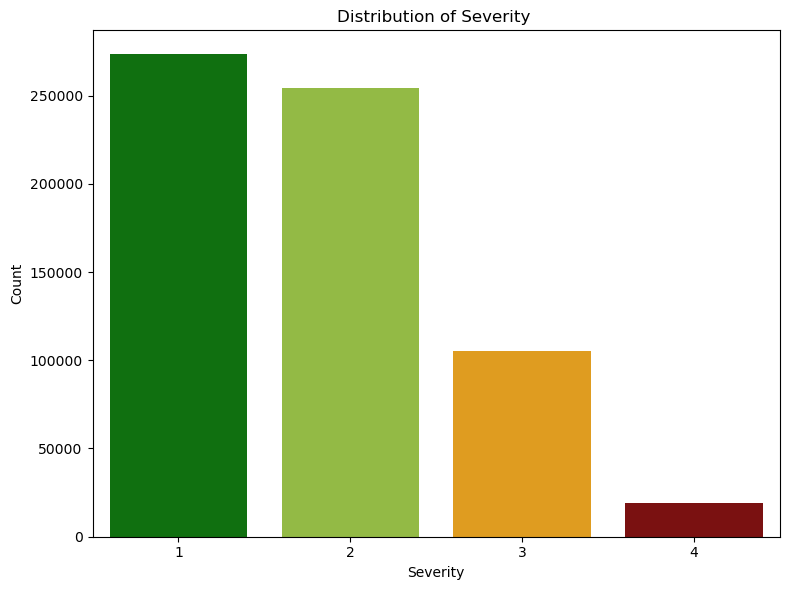

In [120]:
# -------------------------------------------------------------------------------------------------
# show reordered distribution of target variable
#
# the taget variable has an imbalanced distribution
# hospitalized persons and fatalities are much lower
# -------------------------------------------------------------------------------------------------

lib_graph_2.sns_countplot(df_acc_target, 'ind_severity', column_title='Severity', 
                          title='Distribution of Severity', palette_color=colors_grav_reorder)


In [121]:
# -------------------------------------------------------------------------------------------------
# Split df, use stratify
# -------------------------------------------------------------------------------------------------

#accident df: filter for metro
df_metro = df_acc_target[df_acc_target['acc_metro'] == 1]

df_selected_cols = ['acc_ambient_lightning','acc_atmosphere','acc_urbanization_level','acc_intersection','acc_collision_type',
                    'acc_municipality', #'acc_department', 
                    'acc_hour', 'acc_year', #'acc_month', 
                    'ind_severity']

df_metro = df_metro[df_selected_cols]


#shift target values from 1-4 to 0-3 #q
df_metro['ind_severity'] = df_metro['ind_severity']-1


#split df
X = df_metro.drop('ind_severity', axis=1)
y = df_metro['ind_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [122]:
# -------------------------------------------------------------------------------------------------
# Replace nan values
# -------------------------------------------------------------------------------------------------

#replace nan values with mode
def replace_nan(df):
    df['acc_ambient_lightning'].fillna(value = df['acc_ambient_lightning'].mode()[0], inplace=True)
    df['acc_atmosphere'].fillna(value = df['acc_atmosphere'].mode()[0], inplace=True)
    df['acc_urbanization_level'].fillna(value = df['acc_urbanization_level'].mode()[0], inplace=True)
    df['acc_intersection'].fillna(value = df['acc_intersection'].mode()[0], inplace=True)
    df['acc_collision_type'].fillna(value = df['acc_collision_type'].mode()[0], inplace=True)

replace_nan(X_train)
replace_nan(X_test)


In [123]:
# -------------------------------------------------------------------------------------------------
# Encode features
# -------------------------------------------------------------------------------------------------

#accident columns for encoding
acc_categorical_cols = ['acc_ambient_lightning','acc_atmosphere','acc_urbanization_level','acc_intersection','acc_collision_type']
acc_numerical_cols = ['acc_year']
acc_hour_col = ['acc_hour']
acc_month_col = ['acc_month']
acc_cyclical = ['acc_hour'] #, 'acc_month'
acc_location_cols = ['acc_municipality'] #'acc_department', 

#define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), acc_numerical_cols),
        ('catboost', CatBoostEncoder(handle_unknown='impute', handle_missing='impute'), acc_location_cols),
        ('cyclical', CyclicalFeatures(drop_original=True), acc_cyclical),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), acc_categorical_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False #add no prefix to get_feature_names_out
)

pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
    ])

#transform, get encoded df
X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train, y_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

encoded_feature_names = preprocessor.get_feature_names_out()

X_train_encoded_df = pd.DataFrame(X_train_transformed, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_transformed, columns=encoded_feature_names, index=X_test.index)

display(X_train_encoded_df.head())
X_train_encoded_df.info()


,acc_year,acc_municipality,acc_hour_sin,acc_hour_cos,acc_ambient_lightning_2.0,acc_ambient_lightning_3.0,acc_ambient_lightning_4.0,acc_ambient_lightning_5.0,acc_atmosphere_2.0,acc_atmosphere_3.0,acc_atmosphere_4.0,acc_atmosphere_5.0,acc_atmosphere_6.0,acc_atmosphere_7.0,acc_atmosphere_8.0,acc_atmosphere_9.0,acc_urbanization_level_2,acc_intersection_2.0,acc_intersection_3.0,acc_intersection_4.0,acc_intersection_5.0,acc_intersection_6.0,acc_intersection_7.0,acc_intersection_8.0,acc_intersection_9.0,acc_collision_type_2.0,acc_collision_type_3.0,acc_collision_type_4.0,acc_collision_type_5.0,acc_collision_type_6.0,acc_collision_type_7.0
63687,1.455540,0.797286,-0.997669,-0.068242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1333,-0.293595,0.797286,-0.979084,0.203456,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
88524,0.872495,0.797286,0.269797,0.962917,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
93400,-1.459685,0.797286,-0.979084,0.203456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19317,1.455540,0.797286,0.816970,-0.576680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 430912 entries, 63687 to 74531
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   acc_year                   430912 non-null  float64
 1   acc_municipality           430912 non-null  float64
 2   acc_hour_sin               430912 non-null  float64
 3   acc_hour_cos               430912 non-null  float64
 4   acc_ambient_lightning_2.0  430912 non-null  float64
 5   acc_ambient_lightning_3.0  430912 non-null  float64
 6   acc_ambient_lightning_4.0  430912 non-null  float64
 7   acc_ambient_lightning_5.0  430912 non-null  float64
 8   acc_atmosphere_2.0         430912 non-null  float64
 9   acc_atmosphere_3.0         430912 non-null  float64
 10  acc_atmosphere_4.0         430912 non-null  float64
 11  acc_atmosphere_5.0         430912 non-null  float64
 12  acc_atmosphere_6.0         430912 non-null  float64
 13  acc_atmosphere_7.0         4309

In [124]:
# -------------------------------------------------------------------------------------------------
# Decode cyclic features: eg months, hours
#
# Libary: decoding_utils
# -------------------------------------------------------------------------------------------------

sys.path.insert(1, '../../library')
import decoding_utils

importlib.reload(decoding_utils)

#eg: decode hour
df_hour = decoding_utils.decode_cyclic_feature(X_train_encoded_df, 'acc_hour', 24)
df_hour


,acc_hour
63687,18
1333,19
88524,1
93400,19
19317,8
...,...
44573,16
63826,8
2342,10
5769,1


In [22]:
# -------------------------------------------------------------------------------------------------
# Decode one hot encoding, examples
#
# Libary: decoding_utils
# -------------------------------------------------------------------------------------------------

importlib.reload(decoding_utils)

acc_ambient_lightning_cols = ['acc_ambient_lightning_2.0', 
                              'acc_ambient_lightning_3.0', 
                              'acc_ambient_lightning_4.0', 
                              'acc_ambient_lightning_5.0']

df_decoded_lightning = decoding_utils.decode_one_hot(X_train_encoded_df, 
                                      acc_ambient_lightning_cols, 'acc_ambient_lightning')

acc_urbanization_level_cols = ['acc_urbanization_level_2']
df_decoded_urbanization_level = decoding_utils.decode_one_hot(X_train_encoded_df, 
                                      acc_urbanization_level_cols, 'acc_urbanization_level')
df_decoded_urbanization_level


,acc_urbanization_level
0,1
1,2
2,2
3,2
4,1
...,...
430907,2
430908,2
430909,2
430910,2


In [125]:
# -------------------------------------------------------------------------------------------------
# XGBClassifier: Train with class_weight
#
# Classifiaction is done to check out feature importance, shap values
# -------------------------------------------------------------------------------------------------

sample_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4, 
    eval_metric='mlogloss',
    use_label_encoder=False 
)
model.fit(X_train_encoded_df, y_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4, ...)

In [126]:
# -------------------------------------------------------------------------------------------------
# XGBClassifier: Predict
# -------------------------------------------------------------------------------------------------

y_pred = model.predict(X_test_encoded_df)


In [127]:
# -------------------------------------------------------------------------------------------------
# XGBClassifier: predict_proba
# -------------------------------------------------------------------------------------------------

y_proba = model.predict_proba(X_test_encoded_df).round(2)


In [128]:
# -------------------------------------------------------------------------------------------------
# XGBClassifier: classification_report
# -------------------------------------------------------------------------------------------------

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      0.32      0.39     77434
           1       0.48      0.47      0.48     72479
           2       0.28      0.33      0.31     29532
           3       0.09      0.53      0.15      5232

    accuracy                           0.38    184677
   macro avg       0.34      0.41      0.33    184677
weighted avg       0.45      0.38      0.40    184677



In [129]:
# -------------------------------------------------------------------------------------------------
# XGBClassifier: proba_df target classes, with class_weight applied
# -------------------------------------------------------------------------------------------------

class_labels = model.classes_
prob_columns = [f'severity_{c}' for c in class_labels]

proba_df = pd.DataFrame(
    y_proba, #xgb_proba
    columns=prob_columns,
    index = X_test_encoded_df.index
)
proba_df


,severity_0,severity_1,severity_2,severity_3
89070,0.35,0.42,0.14,0.08
25182,0.39,0.39,0.17,0.06
73281,0.33,0.31,0.29,0.06
96720,0.43,0.44,0.10,0.03
24967,0.30,0.15,0.36,0.19
...,...,...,...,...
3304,0.22,0.15,0.37,0.27
51639,0.40,0.46,0.12,0.03
112949,0.23,0.16,0.35,0.26
30416,0.50,0.29,0.05,0.16


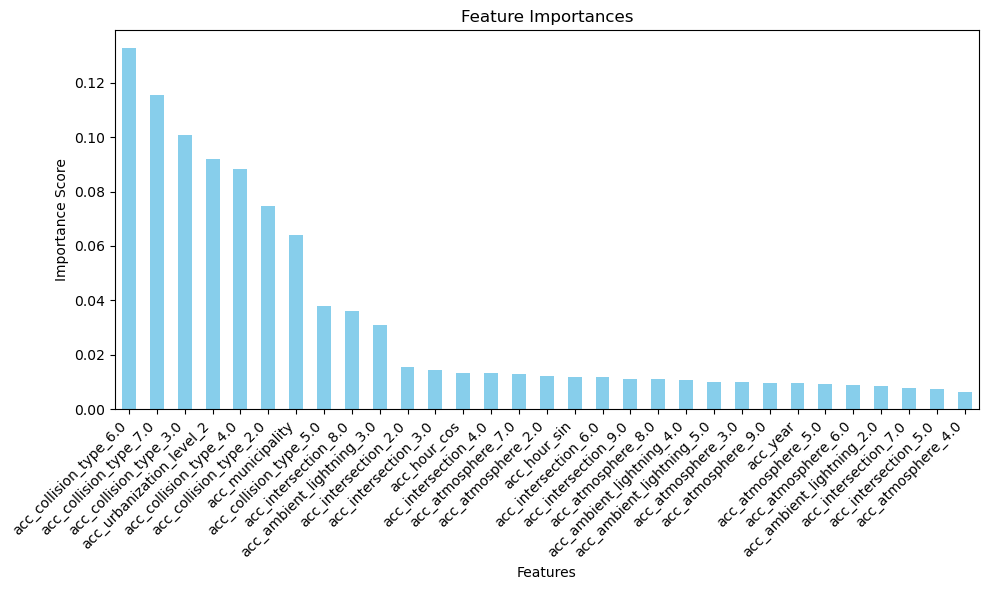

In [130]:
# -------------------------------------------------------------------------------------------------
# XGBClassifier: feature_importances_
# -------------------------------------------------------------------------------------------------

importances = model.feature_importances_

from xgboost import plot_importance
#plt.figure(figsize=(10, 6))
#plot_importance(model)
#plt.show()

feature_importances_series = pd.Series(importances, index=X_test_encoded_df.columns)
sorted_importances = feature_importances_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importances")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [131]:
# -------------------------------------------------------------------------------------------------
# Shap: TreeExplainer, sample
# -------------------------------------------------------------------------------------------------

explainer = shap.TreeExplainer(model, X_train_encoded_df[:1000])
shap_values = explainer(X_test_encoded_df[:200])


 96%|=================== | 767/800 [00:15<00:00]       

In [49]:
# -------------------------------------------------------------------------------------------------
# get shap_values_v (alternative method)
# -------------------------------------------------------------------------------------------------
shap_values_v = explainer.shap_values(X_test_encoded_df[:200])


100%|===================| 797/800 [00:18<00:00]        

In [132]:
# -------------------------------------------------------------------------------------------------
# Shap: display expected values, sample
# -------------------------------------------------------------------------------------------------

# Display the mumber of expected values (corresponding to target classes)
print(f"Number of classes: {len(explainer.expected_value)}")

# Display the expected_value from the TreeExplainer for each class
for i, expected_value in enumerate(explainer.expected_value):
    print(f"Expected value for class {class_labels[i]}: {expected_value}")


Number of classes: 4
Expected value for class 0: 0.1489045523083996
Expected value for class 1: 0.04839986050222819
Expected value for class 2: 0.7114131423515108
Expected value for class 3: 0.3751253201158397


In [133]:
# -------------------------------------------------------------------------------------------------
# Shap: shap_values
# -------------------------------------------------------------------------------------------------

shap_values.values
shap_values.base_values
shap_values.data


array([[ 8.72494591e-01,  6.17047250e-01,  6.31087944e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.93595358e-01,  6.68013255e-01,  1.36166649e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.93595358e-01,  7.27478356e-01, -9.97668769e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.93595358e-01,  9.71040822e-01, -2.44929360e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.93595358e-01,  6.39992133e-01, -6.31087944e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.89449616e-01,  8.56696162e-01,  3.98401090e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

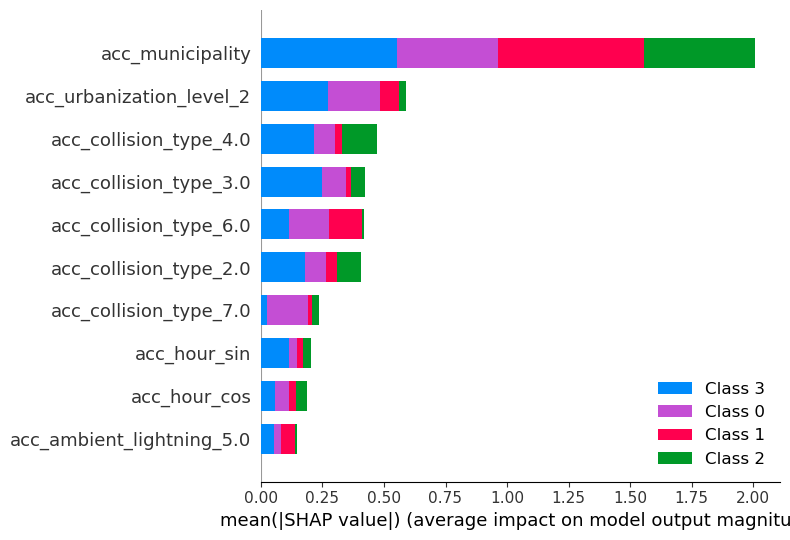

In [134]:
# -------------------------------------------------------------------------------------------------
# Shap: summary bar plot, sample
# -------------------------------------------------------------------------------------------------

shap.summary_plot(shap_values, X_test_encoded_df[:200], plot_type="bar", max_display=10)


<Figure size 640x480 with 0 Axes>

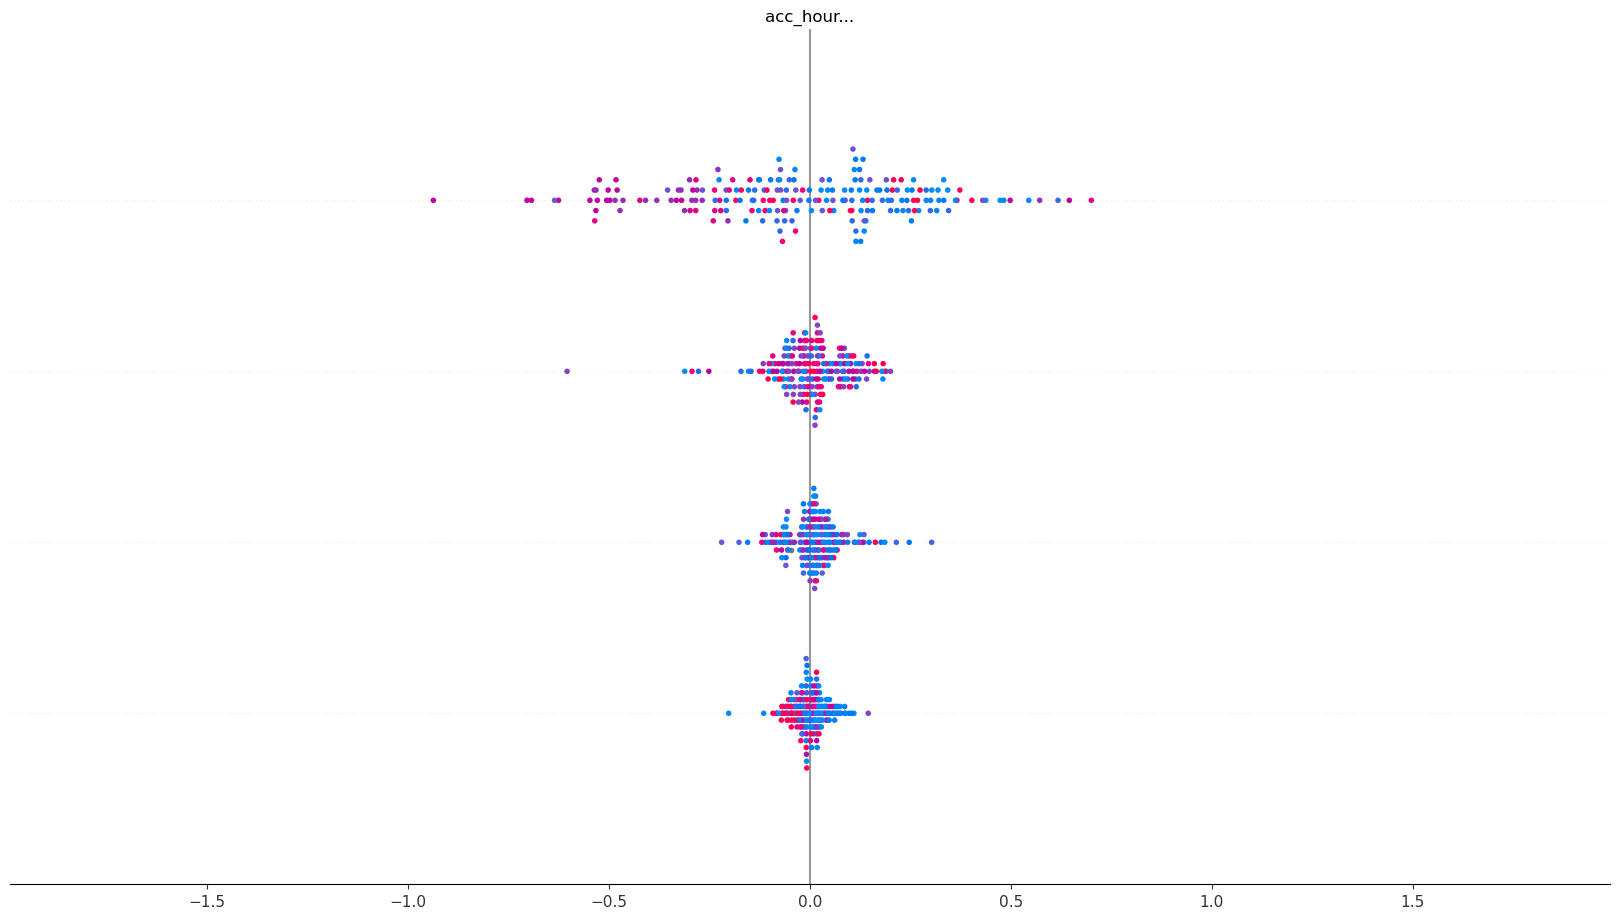

In [135]:
# -------------------------------------------------------------------------------------------------
# Shap: summary plot, sample
# -------------------------------------------------------------------------------------------------

shap.summary_plot(shap_values.values, X_test_encoded_df[:200], max_display=10)


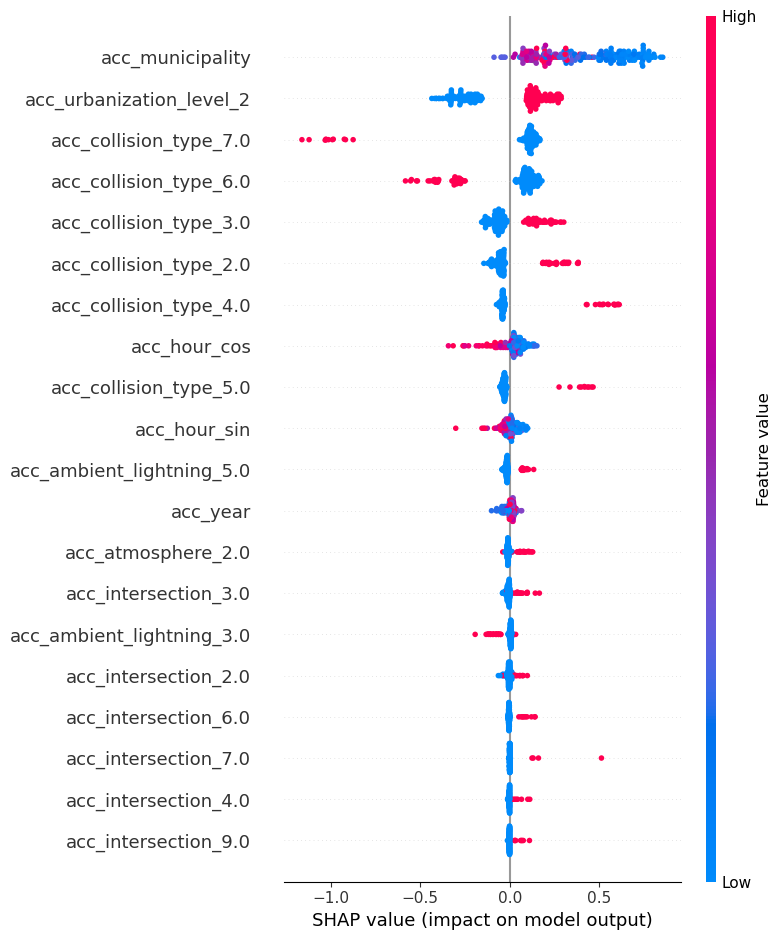

In [136]:
# -------------------------------------------------------------------------------------------------
# Shap: summary plot, sample, class 0
# -------------------------------------------------------------------------------------------------

class_id = 0
shap.summary_plot(shap_values[:, :, class_id], X_test_encoded_df[:200])


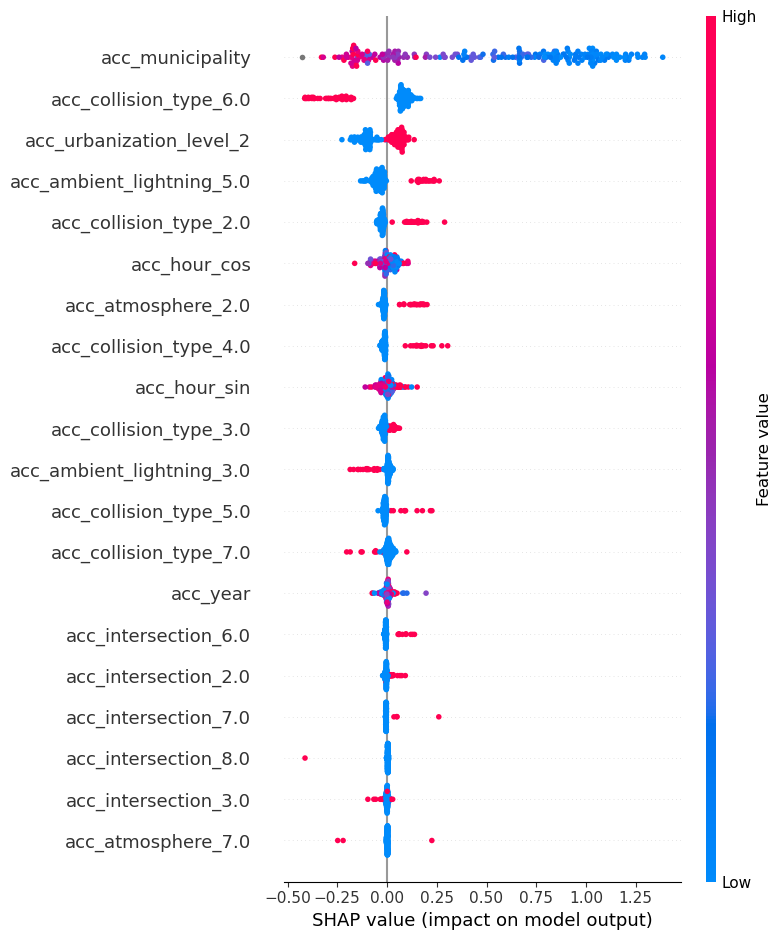

In [137]:
# -------------------------------------------------------------------------------------------------
# Shap: summary plot, sample, class 1
# -------------------------------------------------------------------------------------------------

class_id = 1
shap.summary_plot(shap_values[:, :, class_id], X_test_encoded_df[:200])


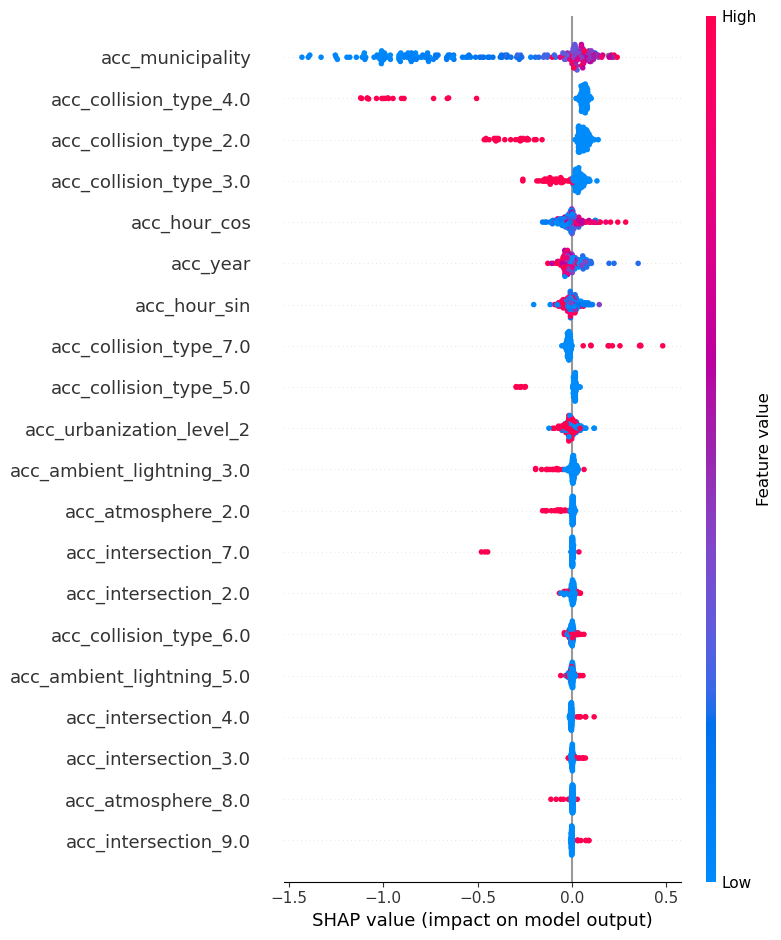

In [138]:
# -------------------------------------------------------------------------------------------------
# Shap: summary plot, sample, class 2
# -------------------------------------------------------------------------------------------------

class_id = 2
shap.summary_plot(shap_values[:, :, class_id], X_test_encoded_df[:200])


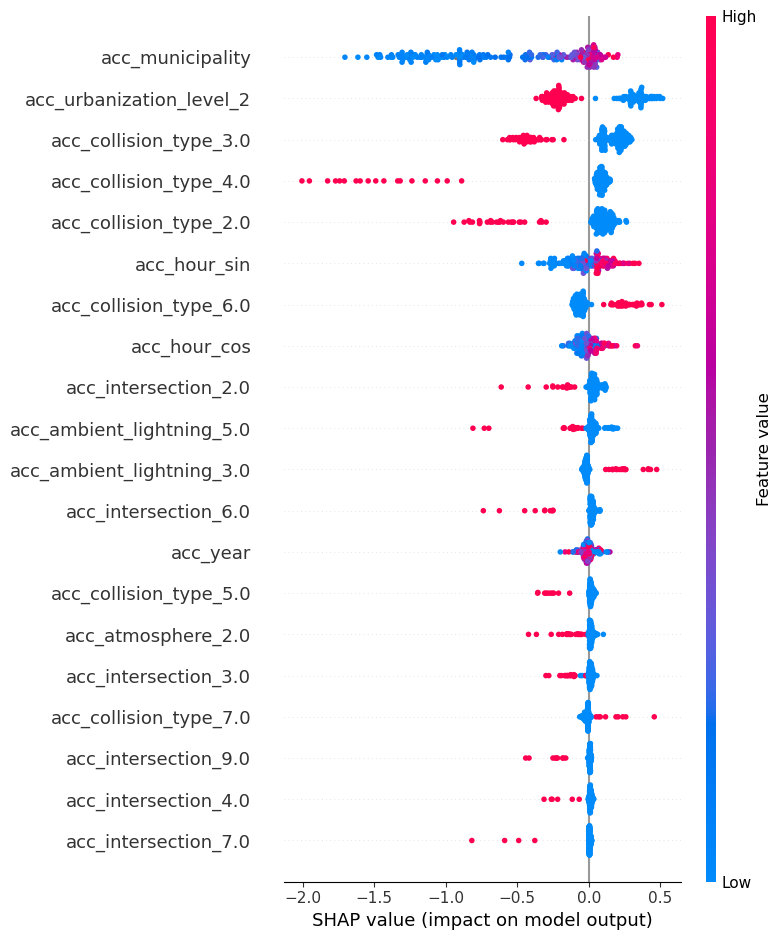

In [139]:
# -------------------------------------------------------------------------------------------------
# Shap: summary plot, sample, class 3
# -------------------------------------------------------------------------------------------------

class_id = 3
shap.summary_plot(shap_values[:, :, class_id], X_test_encoded_df[:200])


In [165]:
# -------------------------------------------------------------------------------------------------
# Shap: shap_values_aggr.aggregate_shap_values
# -------------------------------------------------------------------------------------------------

import shap_values_aggr

#define accident columns dictionary
acc_columns_dict = {
    'acc_year': {'length': 1, 'encoding': 'none'},
    'acc_municipality': {'length': 1, 'encoding': 'none'},
    'acc_hour': {'length': 2, 'encoding': 'hour'},
    'acc_ambient_lightning': {'length': 4, 'encoding': 'ohe'},
    'acc_atmosphere': {'length': 8, 'encoding': 'ohe'},
    'acc_urbanization_level': {'length': 1, 'encoding': 'ohe_one'},
    'acc_intersection': {'length': 8, 'encoding': 'ohe'},
    'acc_collision_type': {'length': 6, 'encoding': 'ohe'},
}

#call aggregate_shap_values
shap_values_r, df_shap_data, df_new_shap_values, org_columns, col_bounderies = shap_values_aggr.aggregate_shap_values(acc_columns_dict, shap_values)

df_shap_data


,acc_year,acc_municipality,acc_hour,acc_ambient_lightning,acc_atmosphere,acc_urbanization_level,acc_intersection,acc_collision_type
0,0.872495,0.617047,9,1,1,1,9,3
1,-0.293595,0.668013,11,1,1,2,1,3
2,-0.293595,0.727478,18,1,1,2,1,3
3,-0.876640,0.665397,19,1,1,2,2,2
4,-0.293595,1.265762,17,1,1,1,1,2
...,...,...,...,...,...,...,...,...
195,-0.293595,0.515744,15,1,1,1,1,4
196,1.455540,0.449321,17,1,1,1,3,3
197,-0.293595,0.971041,0,3,1,1,1,2
198,-0.293595,0.639992,15,1,1,1,1,2


In [159]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregate_shap_values
# -------------------------------------------------------------------------------------------------

importlib.reload(decoding_utils)

def get_col_names(col_name, start_index, end_index, isFloat=True):
    
    col_names = []
    if isFloat:
        float_range = np.arange(start_index, end_index, 1.0)
        for i in float_range:
            col_names.append(f'{col_name}_{i}')
    else:
        for i in range(start_index, end_index):
            col_names.append(f'{col_name}_{i}')
    return col_names


def aggregate_shap_values(columns_dict, shap_values):
    
    #get bounderies of encoded columns
    org_columns = []
    encodings = []
    encoded_lengths = []
    
    for col_id, col_details in columns_dict.items():
        
        org_columns.append(col_id)
        
        for key, value in col_details.items():
        
            if key == 'encoding':
                encodings.append(value)
            elif key == 'length': 
                encoded_lengths.append(value)
    
    col_bounderies = np.cumsum(encoded_lengths)
    
    #create aggregated shap values
    new_shap_values = []
    for values in shap_values.values:
        
        #split shap values into a list for each feature
        values_split = np.split(values , col_bounderies)
        values_split.pop() #remove empty array at end
        #sum values within each list
        values_sum = [sum(l) for l in values_split]
        new_shap_values.append(values_sum)
    
    #create df with aggregated shap values
    df_new_shap_values = pd.DataFrame(new_shap_values, columns=org_columns)
    
    #create stacked aggregated shap values array
    new_shap_values_stacked_rows = [np.stack([df_new_shap_values.iloc[i][col] for col in df_new_shap_values.columns]) for i in range(len(df_new_shap_values))]
    new_shap_values_stacked_array = np.array(new_shap_values_stacked_rows)
    
    #create decoded shap_values.data df
    df_shap_data = pd.DataFrame()
    b=0
    for i, c, e, col in zip(col_bounderies, encoded_lengths, encodings, org_columns):
        
        #print(b, i, c, e, col)
        shap_data = shap_values.data[:,b:i]
        
        if e == 'ohe':
            cols = get_col_names(col, 2.0, round(float(c+2), 1))
            df_r = pd.DataFrame(data=shap_data, columns=cols)
            df_shap_data[col] = decoding_utils.decode_one_hot(df_r, cols, col)
            
        elif e == 'ohe_one':
            df_r = pd.DataFrame(data=shap_data, columns=[col])
            df_r+=1
            df_shap_data[col] = df_r.astype(int)
            
        elif e == 'hour':
            df_hour = pd.DataFrame(data=shap_data, columns=['acc_hour_sin', 'acc_hour_cos'])
            df_shap_data['acc_hour'] = decoding_utils.decode_cyclic_feature(df_hour, 'acc_hour', 24)
            
        else:
            df_shap_data[col] = pd.DataFrame(data=shap_data, columns=[col])
        b=i
    
    #create aggregated shap_values object
    shap_values_r = copy.deepcopy(shap_values)
    
    shap_values_r.values = new_shap_values_stacked_array
    shap_values_r.data = np.array(np.array(df_shap_data))
    shap_values_r.feature_names = list(df_shap_data.columns)
        
    return shap_values_r, df_shap_data, df_new_shap_values, org_columns, col_bounderies


#define accident columns dictionary
acc_columns_dict = {
    'acc_year': {'length': 1, 'encoding': 'none'},
    'acc_municipality': {'length': 1, 'encoding': 'none'},
    'acc_hour': {'length': 2, 'encoding': 'hour'},
    'acc_ambient_lightning': {'length': 4, 'encoding': 'ohe'},
    'acc_atmosphere': {'length': 8, 'encoding': 'ohe'},
    'acc_urbanization_level': {'length': 1, 'encoding': 'ohe_one'},
    'acc_intersection': {'length': 8, 'encoding': 'ohe'},
    'acc_collision_type': {'length': 6, 'encoding': 'ohe'},
}

#call aggregate_shap_values
shap_values_r, df_shap_data, df_new_shap_values, org_columns, col_bounderies = aggregate_shap_values(acc_columns_dict, shap_values)


In [158]:
# -------------------------------------------------------------------------------------------------
# Shap: check dimensions of re-applied shap values
# -------------------------------------------------------------------------------------------------

shap_values_r.values.shape #(200, 8, 4)
shap_values_r.data.shape #(200, 8)
len(shap_values_r.feature_names) #8

shap_values.values.shape #(200, 31, 4)
shap_values.data.shape #(200, 31)
len(shap_values.feature_names) #31


31

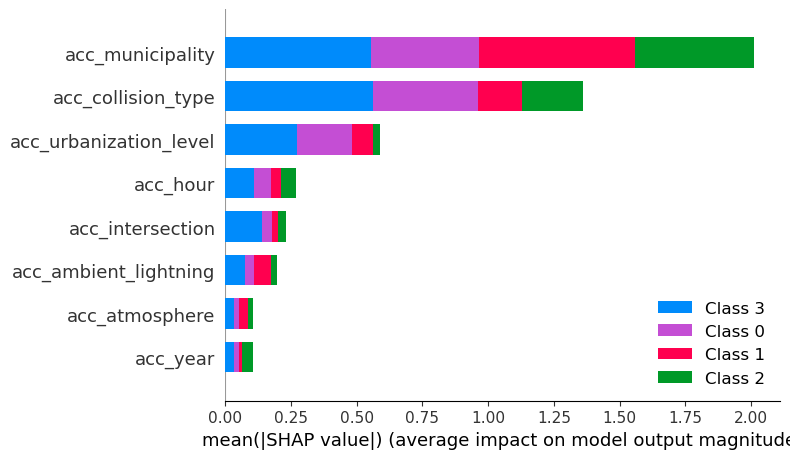

In [142]:
# -------------------------------------------------------------------------------------------------
# Shap: summary plot with aggregated values
# -------------------------------------------------------------------------------------------------

shap.summary_plot(shap_values_r, X_test[:200], plot_type="bar", max_display=10)


<Figure size 640x480 with 0 Axes>

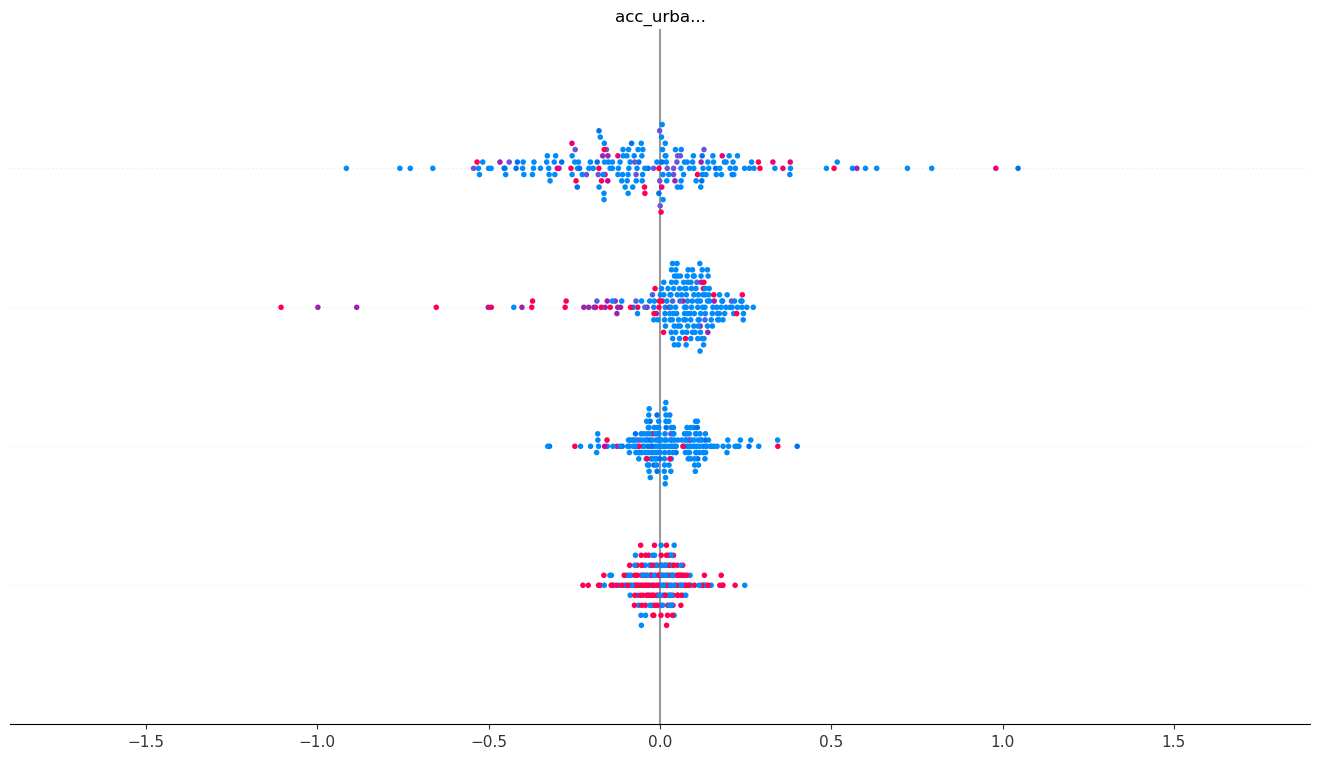

In [143]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, sample
# -------------------------------------------------------------------------------------------------

shap.summary_plot(shap_values_r.values, X_test[:200], max_display=10)


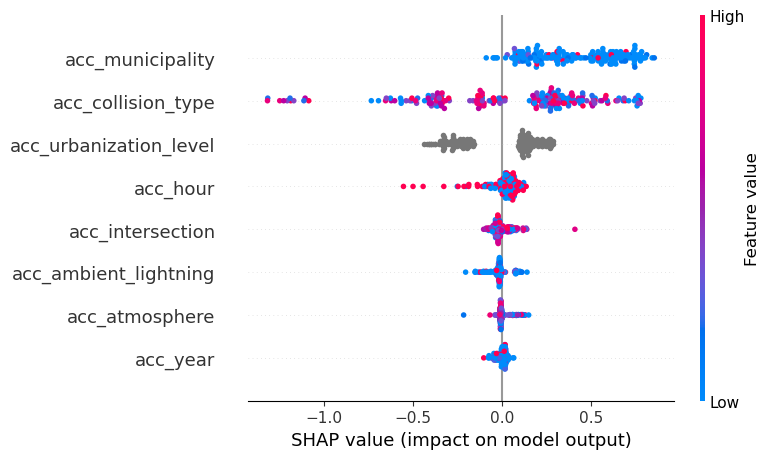

In [144]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, sample, class 0
# -------------------------------------------------------------------------------------------------

class_id = 0
shap.summary_plot(shap_values_r[:, :, class_id], X_test[:200])


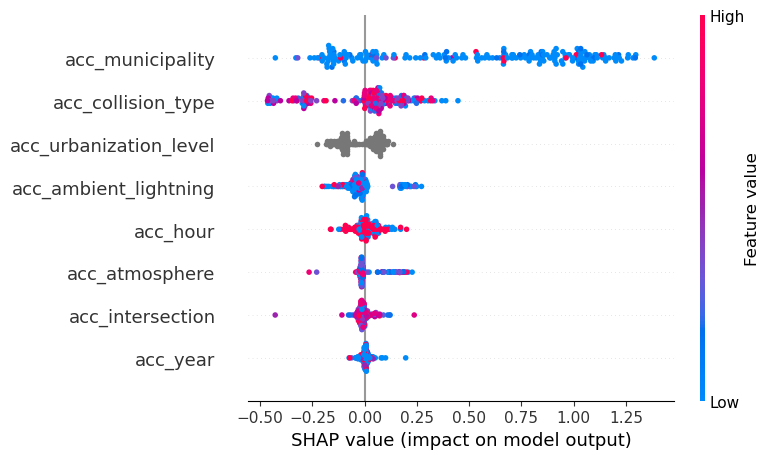

In [145]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, sample, class 1
# -------------------------------------------------------------------------------------------------

class_id = 1
shap.summary_plot(shap_values_r[:, :, class_id], X_test[:200])


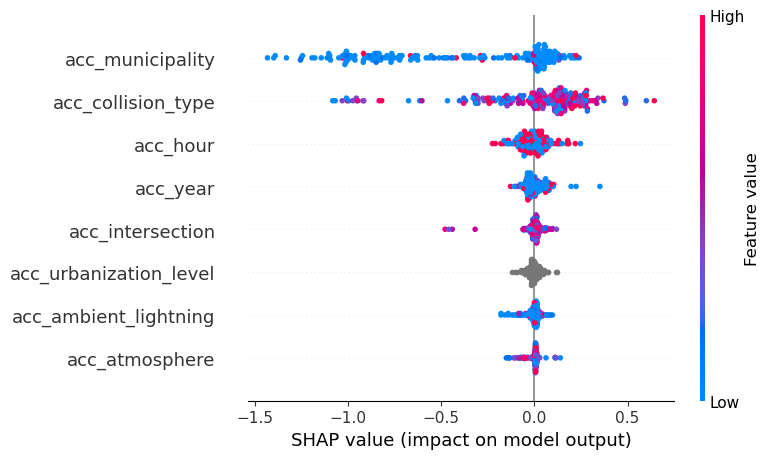

In [146]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, sample, class 2
# -------------------------------------------------------------------------------------------------

class_id = 2
shap.summary_plot(shap_values_r[:, :, class_id], X_test[:200])


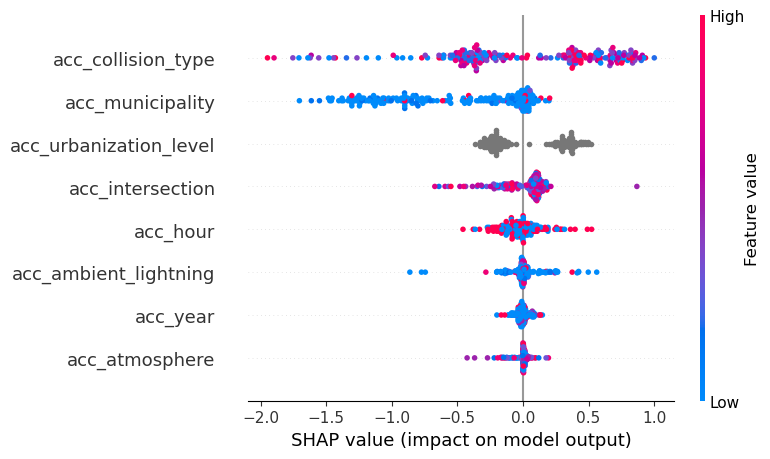

In [147]:
# -------------------------------------------------------------------------------------------------
# Shap: aggregated summary plot, sample, class 3
# -------------------------------------------------------------------------------------------------

class_id = 3
shap.summary_plot(shap_values_r[:, :, class_id], X_test[:200])


In [148]:
# -------------------------------------------------------------------------------------------------
# Shap (experimental: create individual shap values df for each class)
# -------------------------------------------------------------------------------------------------

def create_shap_class_df(df_shap_values, class_id, columns):
    
    df_shap_class = pd.DataFrame(columns=columns)
    
    for index, row in df_shap_values.iterrows():
        
        row_class = []
        for col in columns: 
            row_class.append(row[col][class_id])
        df_shap_class.loc[len(df_shap_class)] = row_class
        
    if 'id' in df_shap_values.columns:
    
        df_shap_class['id'] = df_shap_values['id']
        df_shap_class = df_shap_class.set_index('id')
        df_shap_class.index.name = None
    
    return df_shap_class

acc_columns = ['acc_year', 'acc_municipality','acc_hour',
               'acc_ambient_lightning','acc_atmosphere','acc_urbanization_level','acc_intersection','acc_collision_type']

#create df for each target class
df_shap_0 = create_shap_class_df(df_new_shap_values, 0, acc_columns)
df_shap_1 = create_shap_class_df(df_new_shap_values, 1, acc_columns)
df_shap_2 = create_shap_class_df(df_new_shap_values, 2, acc_columns)
df_shap_3 = create_shap_class_df(df_new_shap_values, 3, acc_columns)

df_shap_0['class'] = 0
df_shap_1['class'] = 1
df_shap_2['class'] = 2
df_shap_3['class'] = 3

combined_df = pd.concat([df_shap_0, df_shap_1, df_shap_2, df_shap_3], ignore_index=True)


In [149]:
# -------------------------------------------------------------------------------------------------
# Shap (experimental: acc_feature_map mask)
# -------------------------------------------------------------------------------------------------

#X_test_encoded_df.info()

acc_feature_map = {
	'acc_year':[
		'acc_year'
		],
	'acc_municipality':[
		'acc_municipality'
		],
	'acc_hour':[
		'acc_hour_sin',
		'acc_hour_cos'
		],
	'acc_ambient_lightning':[
		'acc_ambient_lightning_2.0',
		'acc_ambient_lightning_3.0',
		'acc_ambient_lightning_4.0',
		'acc_ambient_lightning_5.0'
		],
	'acc_atmosphere':[
		'acc_atmosphere_2.0',
		'acc_atmosphere_3.0',
		'acc_atmosphere_4.0',
		'acc_atmosphere_5.0',
		'acc_atmosphere_6.0',
		'acc_atmosphere_7.0',
		'acc_atmosphere_8.0',
		'acc_atmosphere_9.0'
		],
	'acc_urbanization_level':[
		'acc_urbanization_level_2'
		],
	'acc_intersection':[
		'acc_intersection_2.0',
		'acc_intersection_3.0',
		'acc_intersection_4.0',
		'acc_intersection_5.0',
		'acc_intersection_6.0',
		'acc_intersection_7.0',
		'acc_intersection_8.0',
		'acc_intersection_9.0'
        ],
	'acc_collision_type':[
		'acc_collision_type_2.0',
		'acc_collision_type_3.0',
		'acc_collision_type_4.0',
		'acc_collision_type_5.0',
		'acc_collision_type_6.0',
		'acc_collision_type_7.0'
		]
}
